In [5]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST,CIFAR10,FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,ToPILImage
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import random
import os
 



In [3]:
## Set device agnostic code
device=torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")




In [6]:
train_data=FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
test_data=FashionMNIST(root="data",train=False,download=True,transform=ToTensor())


100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100.0%
100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
len(train_data),len(test_data)

(60000, 10000)

Text(0.5, 1.0, '9')

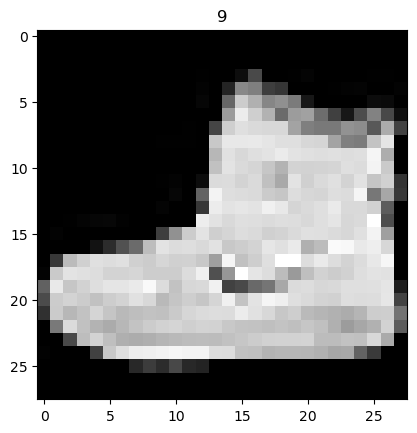

In [11]:
## Visualize the first image
image,label=train_data[0]
plt.imshow(image.squeeze(),cmap="gray")
plt.title(label)


In [13]:

## Create dataloaders
BATCH_SIZE=32
train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [39]:
## Create first CNN model
import torch.nn.functional as F

class FashionMNISTModel_CNN_V0(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_layer_1=nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1)
        self.conv_layer_2=nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_layer_3=nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1)
        self.flatten=nn.Flatten()
        self.fc_layer=nn.Linear(in_features=hidden_units*3*3,out_features=output_shape)
        
    def forward(self,x:torch.Tensor):
        x=self.pool(F.relu(self.conv_layer_1(x)))
        x=self.pool(F.relu(self.conv_layer_2(x)))
        x=self.pool(F.relu(self.conv_layer_3(x)))
        x=self.flatten(x)
        x=self.fc_layer(x)
        return x
    
model=FashionMNISTModel_CNN_V0(input_shape=1,hidden_units=30,output_shape=len(train_data.classes)).to(device)

model.to(device)
        

FashionMNISTModel_CNN_V0(
  (conv_layer_1): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer_3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer): Linear(in_features=270, out_features=10, bias=True)
)

In [40]:
## Create a function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"The model has {count_parameters(model)} trainable parameters")

## Create a function to calculate the accuracy
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct/len(y_pred)*100
    return acc

## Create a loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)



The model has 19270 trainable parameters


In [41]:
## Create a training loop
def train_step(model:nn.Module,data_loader:DataLoader,loss_fn:nn.Module,optimizer:optim.Optimizer,device:torch.device):
    model.train()
    
    train_loss,train_acc=0,0
    
    for batch,(X,y) in enumerate(data_loader):
        optimizer.zero_grad()
        X,y=X.to(device),y.to(device)
        
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss
        loss.backward()
        optimizer.step()
        
        y_pred_class=torch.argmax(y_pred,dim=1)
        train_acc+=accuracy_fn(y,y_pred_class)
        
    train_loss/=len(data_loader)
    train_acc/=len(data_loader)
    
    return train_loss,train_acc


def test_step(model:nn.Module,data_loader:DataLoader,loss_fn:nn.Module,device:torch.device):
    
    
    test_loss,test_acc=0,0
    
    with torch.inference_mode():
        for X,y in data_loader:
            X,y=X.to(device),y.to(device)
            
            y_pred=model(X)
            loss=loss_fn(y_pred,y)
            test_loss+=loss
            
            y_pred_class=torch.argmax(y_pred,dim=1)
            test_acc+=accuracy_fn(y,y_pred_class)
            
    tmp_test_loss=test_loss/len(data_loader)
    tmp_test_acc=test_acc/len(data_loader)
    
    return tmp_test_loss,tmp_test_acc

## Create a function to train and test the model
def train(model:nn.Module,train_dataloader:DataLoader,test_dataloader:DataLoader,loss_fn:nn.Module,optimizer:optim.Optimizer,device:torch.device,epochs:int):
    results={}
    results["train_loss"]=[]
    results["train_acc"]=[]
    results["test_loss"]=[]
    results["test_acc"]=[]
    
    
    for epoch in range(epochs):
        train_loss,train_acc=train_step(model=model,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=device)
        
        test_loss,test_acc=test_step(model=model,data_loader=test_dataloader,loss_fn=loss_fn,device=device)
        
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")
        
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    return results


    
    
 

In [42]:

results=train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=device,epochs=1000)
   

Epoch: 0 | Train loss: 0.5837 | Train acc: 78.75% | Test loss: 0.3809 | Test acc: 86.25%
Epoch: 1 | Train loss: 0.3475 | Train acc: 87.25% | Test loss: 0.3594 | Test acc: 86.71%
Epoch: 2 | Train loss: 0.3052 | Train acc: 88.80% | Test loss: 0.3101 | Test acc: 88.82%
Epoch: 3 | Train loss: 0.2804 | Train acc: 89.67% | Test loss: 0.3092 | Test acc: 88.68%
Epoch: 4 | Train loss: 0.2614 | Train acc: 90.48% | Test loss: 0.2946 | Test acc: 89.51%
Epoch: 5 | Train loss: 0.2490 | Train acc: 90.92% | Test loss: 0.2961 | Test acc: 89.53%
Epoch: 6 | Train loss: 0.2388 | Train acc: 91.28% | Test loss: 0.2952 | Test acc: 89.53%
Epoch: 7 | Train loss: 0.2277 | Train acc: 91.73% | Test loss: 0.3099 | Test acc: 88.94%
Epoch: 8 | Train loss: 0.2189 | Train acc: 92.02% | Test loss: 0.2820 | Test acc: 90.22%
Epoch: 9 | Train loss: 0.2134 | Train acc: 92.23% | Test loss: 0.2826 | Test acc: 90.18%
Epoch: 10 | Train loss: 0.2081 | Train acc: 92.49% | Test loss: 0.2932 | Test acc: 89.51%
Epoch: 11 | Train lo

KeyboardInterrupt: 

In [ ]:
print(results)